<a href="https://colab.research.google.com/github/Kunjsoni2505/Analysis-and-visualization-on-video-game-sales/blob/main/student_performance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
!pip install pywaffle
!pip install catboost
!pip install shap
!pip install lime

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from pywaffle import Waffle
from IPython.display import HTML, display
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
from lime import lime_tabular
import warnings
warnings.filterwarnings('ignore')

In [67]:
student_mat = pd.read_csv("/content/drive/MyDrive/student-por.csv", sep=";")

# Working with student_mat data

In [68]:
student_mat.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]

In [69]:
def display_column_summaries(df):
    summaries = {
        'school': 'Student\'s school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)',
        'sex': 'Student\'s sex (binary: "F" - female or "M" - male)',
        'age': 'Student\'s age (numeric: from 15 to 22)',
        'address': 'Student\'s home address type (binary: "U" - urban or "R" - rural)',
        'famsize': 'Family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)',
        'Pstatus': 'Parent\'s cohabitation status (binary: "T" - living together or "A" - apart)',
        'Medu': 'Mother\'s education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)',
        'Fedu': 'Father\'s education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)',
        'Mjob': 'Mother\'s job (nominal: "teacher", "health" care related, "services" (e.g., administrative or police), "at_home" or "other")',
        'Fjob': 'Father\'s job (nominal: "teacher", "health" care related, "services" (e.g., administrative or police), "at_home" or "other")',
        'reason': 'Reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")',
        'guardian': 'Student\'s guardian (nominal: "mother", "father" or "other")',
        'traveltime': 'Home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)',
        'studytime': 'Weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)',
        'failures': 'Number of past class failures (numeric: n if 1<=n<=3, else 4)',
        'schoolsup': 'Extra educational support (binary: "yes" or "no")',
        'famsup': 'Family educational support (binary: "yes" or "no")',
        'paid': 'Extra paid classes within the course subject (Math or Portuguese) (binary: "yes" or "no")',
        'activities': 'Extra-curricular activities (binary: "yes" or "no")',
        'nursery': 'Attended nursery school (binary: "yes" or "no")',
        'higher': 'Wants to take higher education (binary: "yes" or "no")',
        'internet': 'Internet access at home (binary: "yes" or "no")',
        'romantic': 'With a romantic relationship (binary: "yes" or "no")',
        'famrel': 'Quality of family relationships (numeric: from 1 - very bad to 5 - excellent)',
        'freetime': 'Free time after school (numeric: from 1 - very low to 5 - very high)',
        'goout': 'Going out with friends (numeric: from 1 - very low to 5 - very high)',
        'Dalc': 'Workday alcohol consumption (numeric: from 1 - very low to 5 - very high)',
        'Walc': 'Weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)',
        'health': 'Current health status (numeric: from 1 - very bad to 5 - very good)',
        'absences': 'Number of school absences (numeric: from 0 to 93)',
        'G1': 'First period grade (numeric: from 0 to 20)',
        'G2': 'Second period grade (numeric: from 0 to 20)',
        'G3': 'Final grade (numeric: from 0 to 20)'
    }

    table_html = """
    <style>
        table {
            width: 90%;
            border-collapse: collapse;
            font-family: Arial, sans-serif;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
            color: #333333; /* Header text color */
        }
        tr:nth-child(even) {
            background-color: #f9f9f9; /* Light gray background for even rows */
        }
        tr:nth-child(odd) {
            background-color: #ffffff; /* White background for odd rows */
        }
        td {
            color: #555555; /* Data text color */
        }
    </style>
    <table>
        <tr><th>Column</th><th>Unique Values</th><th>Summary</th></tr>
    """

    for col in df.columns:
        unique_values = df[col].unique()
        table_html += "<tr><td>{}</td><td>{}</td><td>{}</td></tr>".format(
            col, ", ".join(map(str, unique_values)), summaries.get(col, 'No summary available')
        )

    table_html += "</table>"
    display(HTML(table_html))

display_column_summaries(student_mat)


In [70]:
student_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [71]:
student_mat.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std      0.955717    1.051093    1.175766    0.924834    1.284380    1.446259   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    2.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences          G1          G2          G3  
count  649.000000  649.000000  649.000000  649.000000  
mean     3.659476   11.399076   11.570108   11.906009  
std      4.640759    2.745265    2.913639    3.230656  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000   10.000000   10.000000   10.000000  
50%      2.000000   11.000000   11.000000   12.000000  
75%      6.000000   13.000000   13.000000   14.000000  
max     32.000000   19.000000   19.000000   19.000000

## seperating input and output columns

In [72]:
X = student_mat.drop('G3', axis=1)
y = student_mat['G3']

# working with y

In [73]:
y.unique()

array([11, 12, 14, 13, 17, 15,  7, 10, 16,  9,  8, 18,  6,  0,  1,  5, 19])

In [74]:
y.mean()

11.906009244992296

on the basis of mean, selecting the threshold value 10 for pass fail distribution

In [75]:
def pass_fail(grade):
  if grade > 10:
    return 'pass'
  else:
    return 'fail'

y = y.apply(pass_fail)

In [76]:
y.value_counts()

G3
pass    452
fail    197
Name: count, dtype: int64

#Distribution on the basis of target column

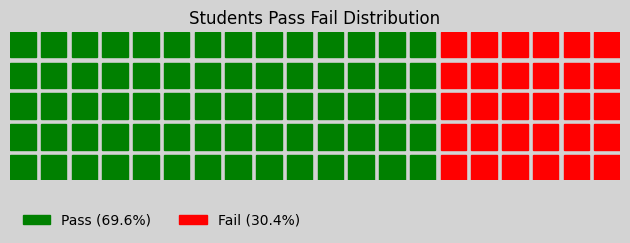

In [77]:
pass_count = y[y == 'pass'].shape[0]
total_students = y.value_counts().sum()

pass_percentage = (pass_count / total_students) * 100
fail_percentage = 100 - pass_percentage

data = {'Pass': pass_percentage, 'Fail': fail_percentage}

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data,
    colors=("green", "red"),
    title={'label': 'Students Pass Fail Distribution', 'loc': 'center'},
    labels=["{0} ({1:.1f}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
)

fig.gca().set_facecolor('lightgray')
fig.set_facecolor('lightgray')
plt.show()


In [78]:
y=y.map({'pass':1,'fail':0})

In [79]:
X

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F   19       R     GT3       T     2     3  services     other   
645     MS   F   18       U     LE3       T     3     1   teacher  services   
646     MS   F   18       U     GT3       T     1     1     other     other   
647     MS   M   17       U     LE3       T     3     1  services  services   
648     MS   M   18       R     LE3       T     3     2  services     other   

     ... romantic famrel  freetime  goout  Dalc Walc health absences  G1  G2  
0    ...       no      4         3      4     1    1      3        4   0  11  
1    ...       no      5         3      3     1    1      3        2   9  11  
2    ...       no      4         3      2     2    3      3        6  12  13  
3    ...      yes      3         2      2     1    1      5        0  14  14  
4    ...       no      4         3      2     1    2      5        0  11  13  
..   ...      ...    ...       ...    ...   ...  ...    ...      ...  ..  ..  
644  ...       no      5         4      2     1    2      5        4  10  11  
645  ...       no      4         3      4     1    1      1        4  15  15  
646  ...       no      1         1      1     1    1      5        6  11  12  
647  ...       no      2         4      5     3    4      2        6  10  10  
648  ...       no      4         4      1     3    4      5        4  10  11  

[649 rows x 32 columns]

# working on x

In [80]:
gender_grades = student_mat.groupby('sex')[['G1', 'G2', 'G3']].mean()

# Create a line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=gender_grades.columns, y=gender_grades.loc['F'], mode='lines+markers', name='Female'))
fig.add_trace(go.Scatter(x=gender_grades.columns, y=gender_grades.loc['M'], mode='lines+markers', name='Male'))
fig.update_layout(
    title='Average Grades by Gender',
    xaxis_title='Period',
    yaxis_title='Average Grade'
)
fig.show()

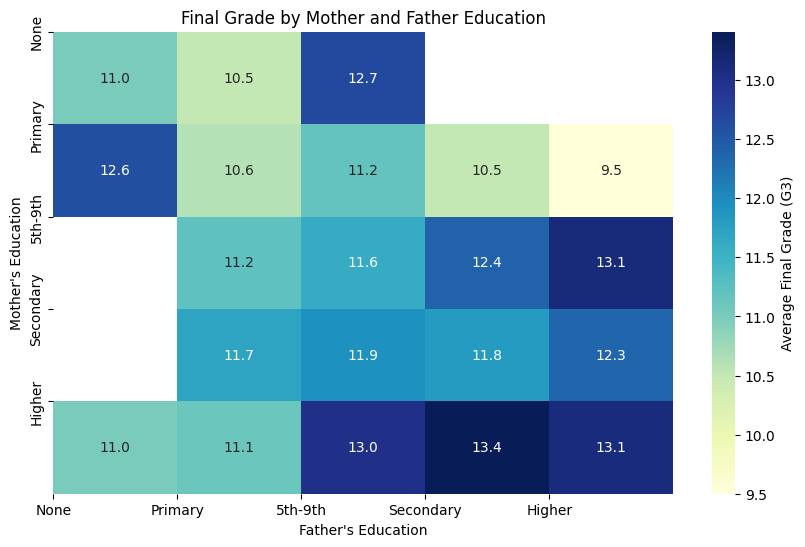

In [81]:
grade_by_parents_edu = student_mat.groupby(['Medu', 'Fedu'])['G3'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(grade_by_parents_edu, annot=True, cmap='YlGnBu', fmt='.1f', cbar_kws={'label': 'Average Final Grade (G3)'})
plt.title('Final Grade by Mother and Father Education')
plt.xlabel('Father\'s Education')
plt.ylabel('Mother\'s Education')
plt.xticks(np.arange(5), ['None', 'Primary', '5th-9th', 'Secondary', 'Higher'])
plt.yticks(np.arange(5), ['None', 'Primary', '5th-9th', 'Secondary', 'Higher'])
plt.show()

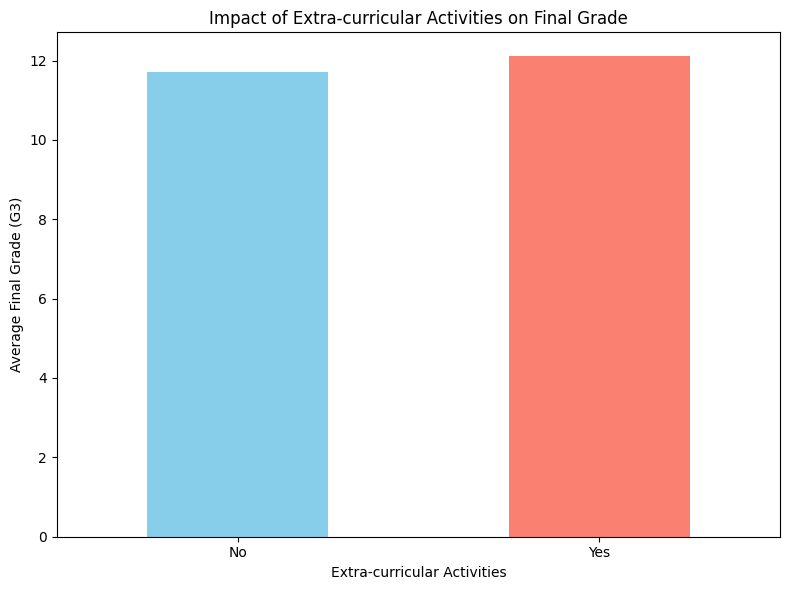

In [82]:
activities_impact = student_mat.groupby('activities')['G3'].mean()

plt.figure(figsize=(8, 6))
activities_impact.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Impact of Extra-curricular Activities on Final Grade')
plt.xlabel('Extra-curricular Activities')
plt.ylabel('Average Final Grade (G3)')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()


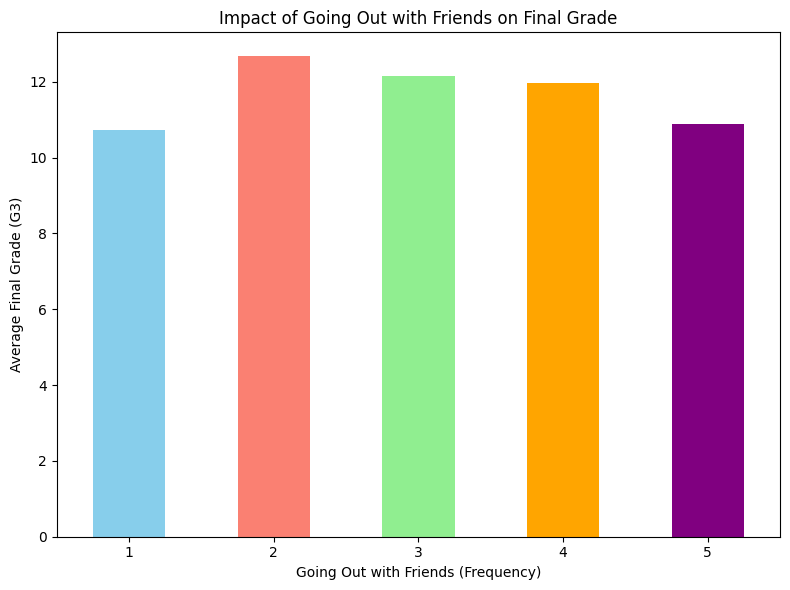

In [83]:
goout_impact = student_mat.groupby('goout')['G3'].mean()

plt.figure(figsize=(8, 6))
goout_impact.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'])
plt.title('Impact of Going Out with Friends on Final Grade')
plt.xlabel('Going Out with Friends (Frequency)')
plt.ylabel('Average Final Grade (G3)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


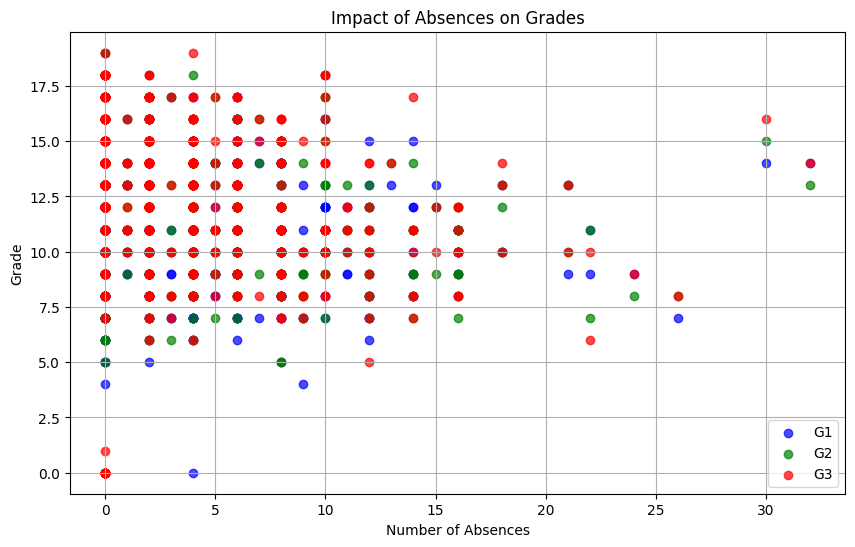

In [84]:
plt.figure(figsize=(10, 6))

plt.scatter(student_mat['absences'], student_mat['G1'], label='G1', alpha=0.7, color='blue')
plt.scatter(student_mat['absences'], student_mat['G2'], label='G2', alpha=0.7, color='green')
plt.scatter(student_mat['absences'], student_mat['G3'], label='G3', alpha=0.7, color='red')

plt.title('Impact of Absences on Grades')
plt.xlabel('Number of Absences')
plt.ylabel('Grade')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# 3d scatter plot

In [85]:
fig = px.scatter_3d(student_mat, x='G1', y='G2', z='G3', color='studytime', title='3D Scatter Plot of Student Grades and Study Time')
fig.show()

# tree map

In [86]:
fig = px.treemap(student_mat, path=['famsize', 'Pstatus', 'G3'], values='G3', title='Treemap of Family Size, Parental Status, and Final Grades')
fig.show()

# preprocessing

In [87]:
X.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  romantic famrel  freetime  goout  Dalc Walc health absences  G1  G2  
0       no      4         3      4     1    1      3        4   0  11  
1       no      5         3      3     1    1      3        2   9  11  
2       no      4         3      2     2    3      3        6  12  13  
3      yes      3         2      2     1    1      5        0  14  14  
4       no      4         3      2     1    2      5        0  11  13  

[5 rows x 32 columns]

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [89]:
non_numeric_cols = X.select_dtypes(exclude=['int64']).columns

for col in non_numeric_cols:
  le = LabelEncoder()
  X[col] = le.fit_transform(X[col])


In [90]:
X

school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0         0    0   18        1        0        0     4     4     0     4  ...   
1         0    0   17        1        0        1     1     1     0     2  ...   
2         0    0   15        1        1        1     1     1     0     2  ...   
3         0    0   15        1        0        1     4     2     1     3  ...   
4         0    0   16        1        0        1     3     3     2     2  ...   
..      ...  ...  ...      ...      ...      ...   ...   ...   ...   ...  ...   
644       1    0   19        0        0        1     2     3     3     2  ...   
645       1    0   18        1        1        1     3     1     4     3  ...   
646       1    0   18        1        0        1     1     1     2     2  ...   
647       1    1   17        1        1        1     3     1     3     3  ...   
648       1    1   18        0        1        1     3     2     3     2  ...   

     romantic  famrel  freetime  goout  Dalc  Walc  health  absences  G1  G2  
0           0       4         3      4     1     1       3         4   0  11  
1           0       5         3      3     1     1       3         2   9  11  
2           0       4         3      2     2     3       3         6  12  13  
3           1       3         2      2     1     1       5         0  14  14  
4           0       4         3      2     1     2       5         0  11  13  
..        ...     ...       ...    ...   ...   ...     ...       ...  ..  ..  
644         0       5         4      2     1     2       5         4  10  11  
645         0       4         3      4     1     1       1         4  15  15  
646         0       1         1      1     1     1       5         6  11  12  
647         0       2         4      5     3     4       2         6  10  10  
648         0       4         4      1     3     4       5         4  10  11  

[649 rows x 32 columns]

showing heatmap

In [91]:
corr = X.corr()
fig = px.imshow(corr, color_continuous_scale='RdBu', title='Correlation Heatmap',
                 width=800, height=800,
                 x=corr.columns, y=corr.columns,
                 labels=dict(color="Correlation"),
                 text_auto='.2f')
fig.show()

In [92]:
X_c = X
y_c = y

# feature selection

In [93]:
mutual_scr = mutual_info_classif(X, y)
mutual_scr_series = pd.Series(mutual_scr, index=X.columns)
mutual_scr_series.sort_values(ascending=False, inplace=True)
print(mutual_scr_series)

G2            0.383595
G1            0.316173
failures      0.097312
school        0.057221
Medu          0.054700
higher        0.030611
goout         0.024845
famsize       0.023278
studytime     0.023192
Pstatus       0.021409
paid          0.020300
internet      0.018293
traveltime    0.017350
sex           0.016859
Fjob          0.016400
address       0.013114
absences      0.012452
famrel        0.008584
freetime      0.008395
nursery       0.006257
famsup        0.005459
Walc          0.004127
Mjob          0.002735
schoolsup     0.002471
romantic      0.000000
guardian      0.000000
reason        0.000000
Dalc          0.000000
health        0.000000
Fedu          0.000000
age           0.000000
activities    0.000000
dtype: float64


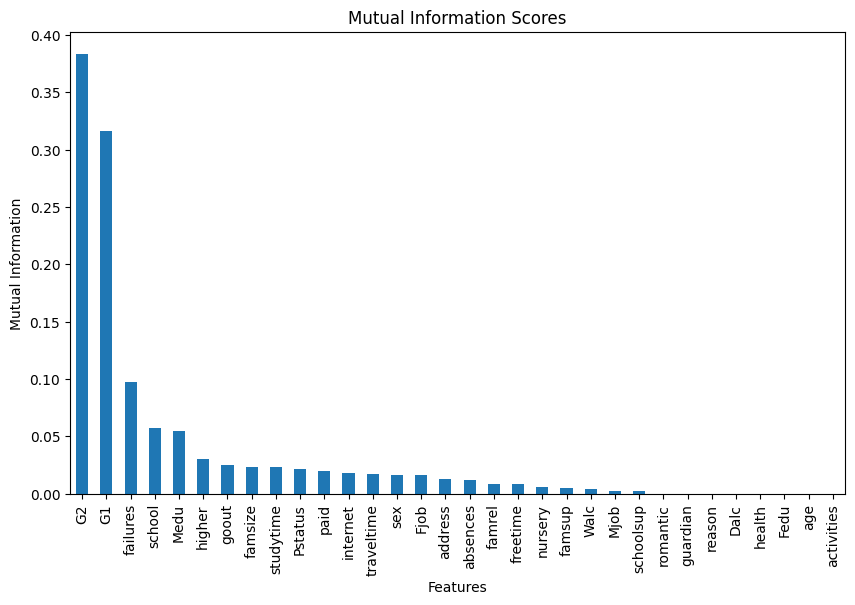

In [94]:
mutual_scr_series.plot.bar(figsize=(10, 6))
plt.title('Mutual Information Scores')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

Selected features

In [95]:
selected_features = mutual_scr_series[mutual_scr_series > 0.0].index
X = X[selected_features]

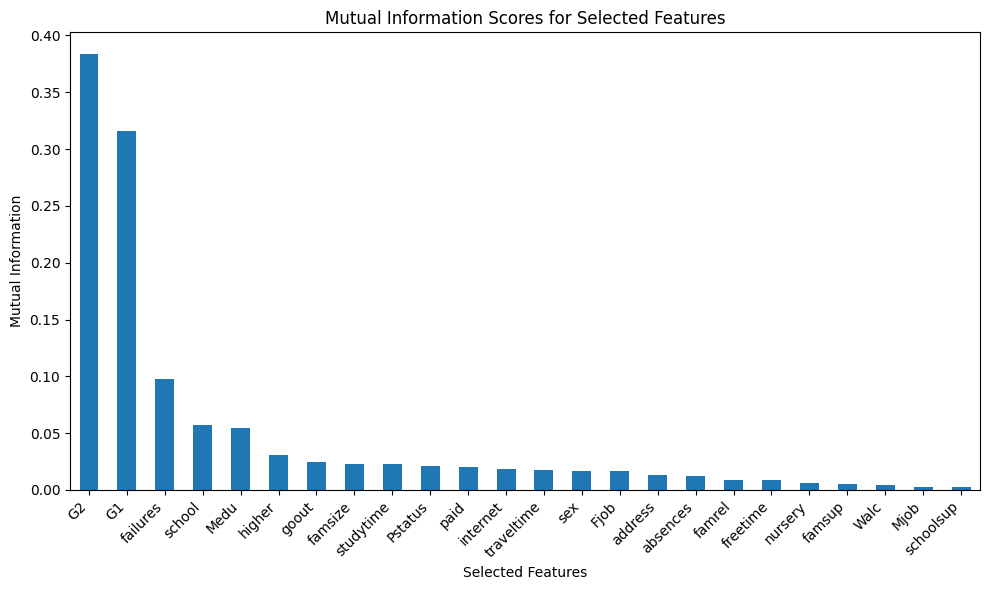

In [96]:
plt.figure(figsize=(10, 6))
mutual_scr_series[mutual_scr_series > 0.0].plot.bar()
plt.title('Mutual Information Scores for Selected Features')
plt.xlabel('Selected Features')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [97]:
X.describe()

G2          G1    failures      school        Medu      higher  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    11.570108   11.399076    0.221880    0.348228    2.514638    0.893683   
std      2.913639    2.745265    0.593235    0.476776    1.134552    0.308481   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     10.000000   10.000000    0.000000    0.000000    2.000000    1.000000   
50%     11.000000   11.000000    0.000000    0.000000    2.000000    1.000000   
75%     13.000000   13.000000    0.000000    1.000000    4.000000    1.000000   
max     19.000000   19.000000    3.000000    1.000000    4.000000    1.000000   

            goout     famsize   studytime     Pstatus  ...        Fjob  \
count  649.000000  649.000000  649.000000  649.000000  ...  649.000000   
mean     3.184900    0.295840    1.930663    0.876733  ...    2.224961   
std      1.175766    0.456771    0.829510    0.328996  ...    0.863487   
min      1.000000    0.000000    1.000000    0.000000  ...    0.000000   
25%      2.000000    0.000000    1.000000    1.000000  ...    2.000000   
50%      3.000000    0.000000    2.000000    1.000000  ...    2.000000   
75%      4.000000    1.000000    2.000000    1.000000  ...    3.000000   
max      5.000000    1.000000    4.000000    1.000000  ...    4.000000   

          address    absences      famrel    freetime     nursery      famsup  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     0.696456    3.659476    3.930663    3.180277    0.802773    0.613251   
std      0.460143    4.640759    0.955717    1.051093    0.398212    0.487381   
min      0.000000    0.000000    1.000000    1.000000    0.000000    0.000000   
25%      0.000000    0.000000    4.000000    3.000000    1.000000    0.000000   
50%      1.000000    2.000000    4.000000    3.000000    1.000000    1.000000   
75%      1.000000    6.000000    5.000000    4.000000    1.000000    1.000000   
max      1.000000   32.000000    5.000000    5.000000    1.000000    1.000000   

             Walc        Mjob   schoolsup  
count  649.000000  649.000000  649.000000  
mean     2.280431    1.941448    0.104777  
std      1.284380    1.248317    0.306502  
min      1.000000    0.000000    0.000000  
25%      1.000000    1.000000    0.000000  
50%      2.000000    2.000000    0.000000  
75%      3.000000    3.000000    0.000000  
max      5.000000    4.000000    1.000000  

[8 rows x 24 columns]

In [98]:
X_fNames = X.columns

# apply min max scaling

In [99]:
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X)

In [100]:
X

array([[0.57894737, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.57894737, 0.47368421, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.68421053, 0.63157895, 0.        , ..., 0.5       , 0.        ,
        1.        ],
       ...,
       [0.63157895, 0.57894737, 0.        , ..., 0.        , 0.5       ,
        0.        ],
       [0.52631579, 0.52631579, 0.        , ..., 0.75      , 0.75      ,
        0.        ],
       [0.57894737, 0.52631579, 0.        , ..., 0.75      , 0.75      ,
        0.        ]])

# apply data balancing using smote

In [101]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

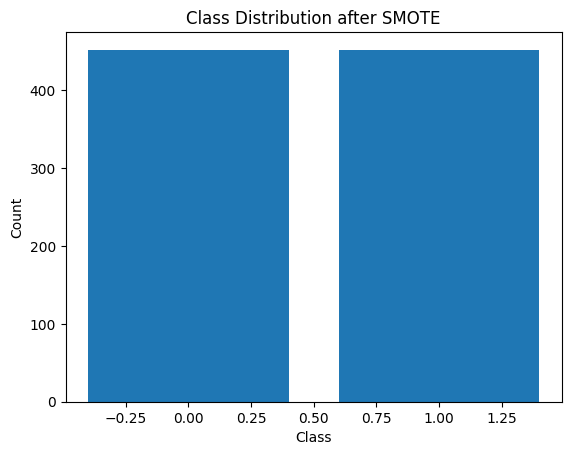

In [102]:
plt.bar(y.value_counts().index, y.value_counts().values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution after SMOTE')
plt.show()

# train test split (80:20)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((723, 24), (181, 24), (723,), (181,))

## machine learning model implimentation

# catboost

In [104]:
cat = CatBoostClassifier(verbose=0)
cat.fit(X_train, y_train)
y_matPred = cat.predict(X_test)

## for testing

In [105]:
def calculat_scores(data, y_pred):

  accuracy = accuracy_score(data, y_pred)
  precision = precision_score(data, y_pred)
  recall = recall_score(data, y_pred)
  f1 = f1_score(data, y_pred)
  auc = roc_auc_score(data, y_pred)

  return {
      'accuracy' : accuracy,
      'precision': precision,
      'recall'   : recall,
      'f1_score' : f1,
      'auc'      : auc
  }

def print_scores(metrics):

  print("Accuracy : {:.4f}".format(metrics['accuracy']))
  print("Precision: {:.4f}".format(metrics['precision']))
  print("Recall   : {:.4f}".format(metrics['recall']))
  print("F1-score : {:.4f}".format(metrics['f1_score']))
  print("AUC      : {:.4f}".format(metrics['auc']))

In [106]:
print_scores(calculat_scores(y_test, y_matPred))

Accuracy : 0.9558
Precision: 0.9674
Recall   : 0.9468
F1-score : 0.9570
AUC      : 0.9562


In [107]:
def conf_mat(data, y_pred):
  cm = confusion_matrix(data, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  if data.name == 'y_test':
    plt.title('Confusion Matrix for Test Data')
  else:
    plt.title('Confusion Matrix for Train Data')
  plt.show()

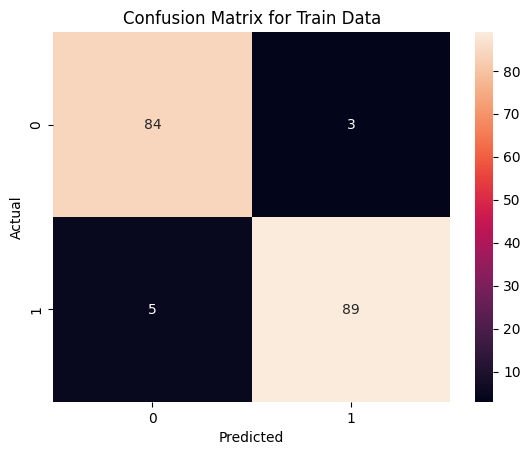

In [108]:
conf_mat(y_test, y_matPred)

In [109]:
print(classification_report(y_test, y_matPred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        87
           1       0.97      0.95      0.96        94

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181



## for training

In [110]:
y_matPred = cat.predict(X_train)

In [111]:
print_scores(calculat_scores(y_train, y_matPred))

Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
AUC      : 1.0000


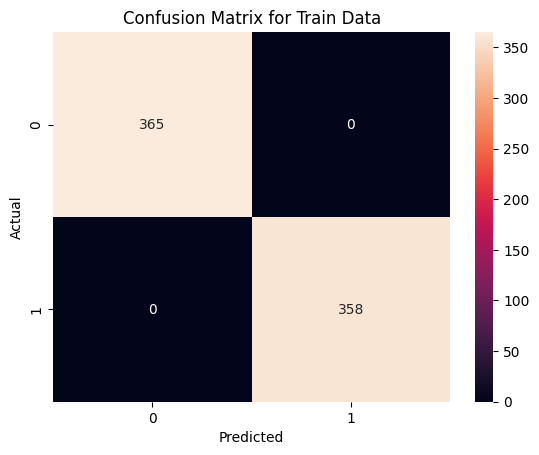

In [112]:
conf_mat(y_train, y_matPred)

In [113]:
print(classification_report(y_train, y_matPred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       1.00      1.00      1.00       358

    accuracy                           1.00       723
   macro avg       1.00      1.00      1.00       723
weighted avg       1.00      1.00      1.00       723



# Gradient Boost classifier

In [114]:
gb = GradientBoostingClassifier(n_estimators= 100, max_depth=3)
gb.fit(X_train, y_train)
y_matPred = gb.predict(X_test)

# for testing

In [115]:
print_scores(calculat_scores(y_test, y_matPred))

Accuracy : 0.9337
Precision: 0.9271
Recall   : 0.9468
F1-score : 0.9368
AUC      : 0.9332


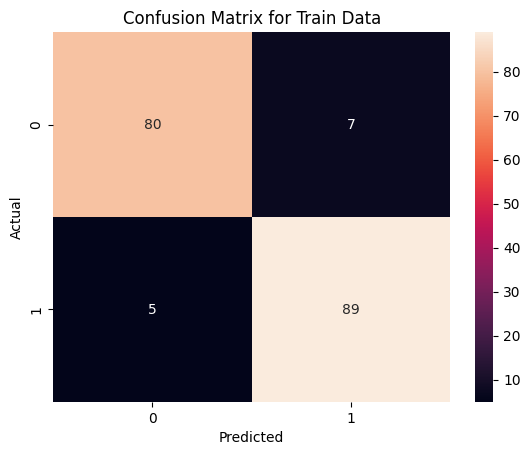

In [116]:
conf_mat(y_test, y_matPred)

In [117]:
print(classification_report(y_test, y_matPred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        87
           1       0.93      0.95      0.94        94

    accuracy                           0.93       181
   macro avg       0.93      0.93      0.93       181
weighted avg       0.93      0.93      0.93       181



# for training

In [118]:
y_matPred = gb.predict(X_train)

In [119]:
print_scores(calculat_scores(y_train, y_matPred))

Accuracy : 0.9862
Precision: 0.9860
Recall   : 0.9860
F1-score : 0.9860
AUC      : 0.9862


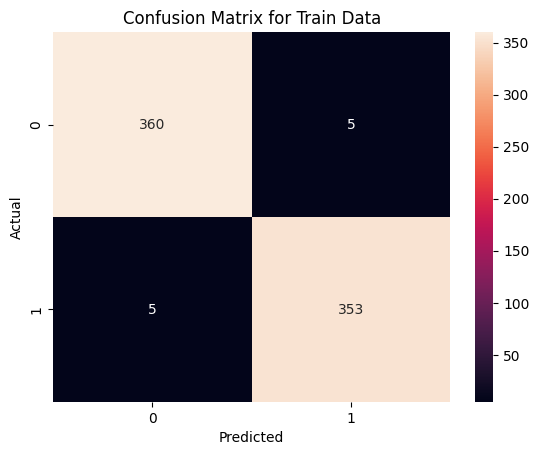

In [120]:
conf_mat(y_train, y_matPred)

In [121]:
print(classification_report(y_train, y_matPred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       365
           1       0.99      0.99      0.99       358

    accuracy                           0.99       723
   macro avg       0.99      0.99      0.99       723
weighted avg       0.99      0.99      0.99       723



# shap

In [122]:
shap.initjs()
explainer = shap.TreeExplainer(cat)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...])

In [123]:
shap.initjs()
shap.plots.force(shap_values, feature_names=X_fNames)

In [124]:
# Create a LimeTabularExplainer object
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_fNames,
    class_names=['Fail', 'Pass'],
    mode='classification'
)

indx = 0
instance = X_test[indx]

# Generating an explanation for instance
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=cat.predict_proba
)

# Display the explanation
explanation.show_in_notebook(show_table=True)


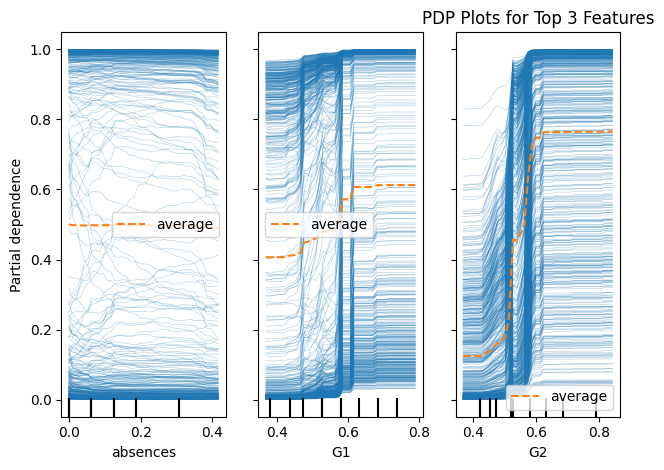

In [125]:
from sklearn.inspection import PartialDependenceDisplay

# Select top 3 features based on shap values
top_3_features = ['absences', 'G1', 'G2']

# Creating PartialDependenceDisplay for the top 3 features
display = PartialDependenceDisplay.from_estimator(
    cat,
    X_train,
    features=top_3_features,
    kind="both",
    feature_names=X_fNames,
    grid_resolution=40,
    random_state=42
)
plt.title("PDP Plots for Top 3 Features")
plt.tight_layout()
plt.show()

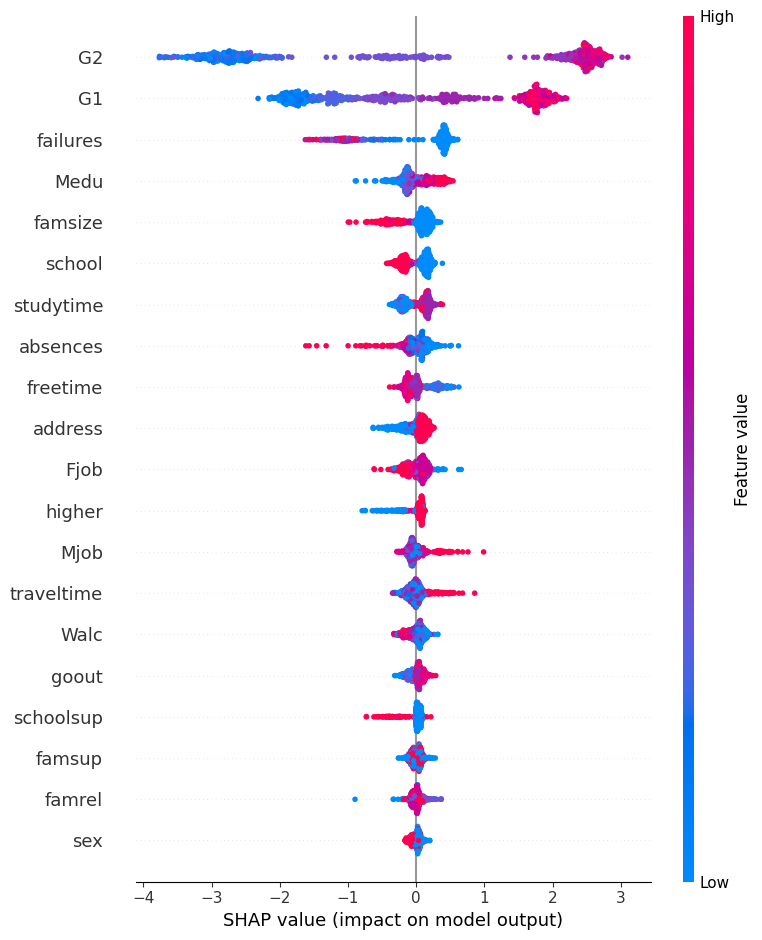

In [126]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=X_fNames)

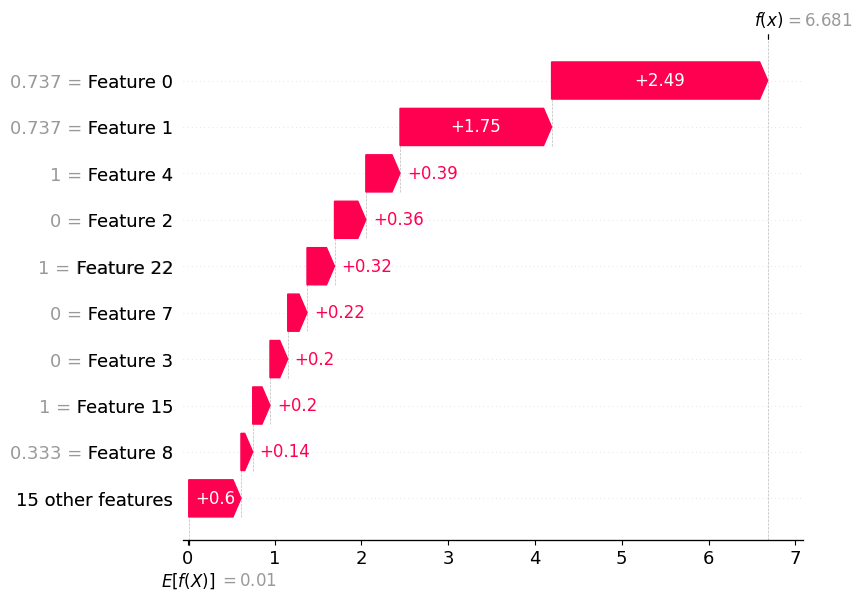

In [127]:
shap.plots.waterfall(shap_values[0])